In [211]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from sklearn.utils import shuffle
import librosa
from sklearn.model_selection import train_test_split 

In [55]:
# load the MLP Data
DATA = r"E:\Documents\My Projects\Filtr\Data\Serialized\MLP_large.pkl"

# Data Analysis

### Shuffling the data
Using the .sample() method of your dataframe to sample all rows without replacement:
```python
df.sample(frac=1)
```
The frac keyword argument specifies the fraction of rows to return in the random sample, so frac=1 means return all rows (in random order).

_We can also use other libraries to shuffle our dataset_

Below I used sklearns shuffle method

In [279]:
#df = df.sample(frac=1, random_state=0)
#np.random.shuffle(df)

df = pd.read_pickle(DATA) 
df = shuffle(df,random_state = 21)

In [280]:
df.rename(columns={'class':'label'},inplace=True)
df.head()

,label,Filename,Duration,Channels,Sample_rate,Bit_depth,path,Data
9148,Pads,RSL_95_synth_pad_chop_mothers_luv_D#m.wav,10.13,2,44100,24,E:\Documents\My Projects\Filtr\Data\Audio\Pads...,"[-1.0, 0.41120592, -0.013396348, -0.09519886, ..."
5763,Guitar,Cymatics - Drip Guitar Loop 9 - 160 BPM F Min.wav,6.00,2,44100,16,E:\Documents\My Projects\Filtr\Data\Audio\Guit...,"[-1.0, 0.58382785, 0.06277005, 0.067871064, 0...."
2248,FX,wafx_shortfx_leashfreak.wav,1.80,2,44100,24,E:\Documents\My Projects\Filtr\Data\Audio\FX\w...,"[-0.26646873, 1.0, -0.541562, 0.105186634, -0...."
12367,Percs,UZ_SS_percussion_wet_drop_03.wav,0.21,2,44100,24,E:\Documents\My Projects\Filtr\Data\Audio\Perc...,"[-1.0, 0.06122127, -0.10765891, -0.016434945, ..."
4581,Synth,V_RIOT_bass_one_shot_raw_skrill_08_low.wav,0.85,2,44100,24,E:\Documents\My Projects\Filtr\Data\Audio\Synt...,"[-1.0, 0.83497876, -0.47013032, 0.56361425, 0...."


In [281]:
# count the values for each class
df['label'].value_counts()

FX             1426
Synth          1192
Percs          1188
Kick           1175
Snare          1157
Instrument     1152
hats           1068
Vox            1060
Cymbals        1060
Foley          1027
808             976
Pads            859
Guitar          853
Transitions     757
Impacts         488
Snaps           406
Name: label, dtype: int64

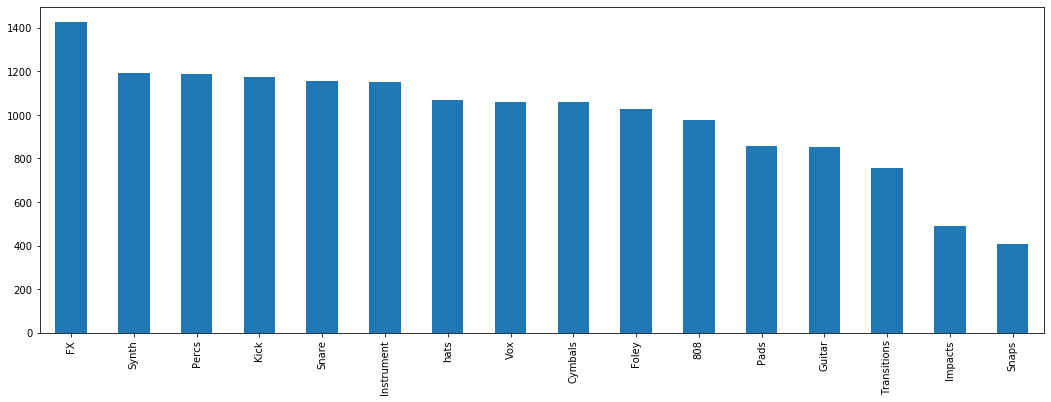

In [282]:
# graphingthe class size distribution
df['label'].value_counts(ascending = False).plot(kind = 'bar',figsize = (18,6))

In [295]:
# reduced dataset
df2 = df.copy()
df2 = df2.query('label == ["Kick","Snare"]')
df2.head()

,label,Filename,Duration,Channels,Sample_rate,Bit_depth,path,Data
10872,Kick,Kick #5.wav,0.74,2,44100,24,E:\Documents\My Projects\Filtr\Data\Audio\Kick...,"[-1.0, 0.083789736, 0.031673606, 0.023578444, ..."
10997,Kick,fuck kick.wav,0.49,2,0,0,E:\Documents\My Projects\Filtr\Data\Audio\Kick...,"[-1.0, 0.14266708, 0.06761246, 0.07021363, 0.0..."
10396,Snare,FLO - Snare 19.wav,0.68,2,44100,24,E:\Documents\My Projects\Filtr\Data\Audio\Snar...,"[-1.0, 0.04868256, -0.08974855, -0.00010369084..."
11335,Kick,BWB WAV 6 KICK (11).wav,0.53,2,44100,32,E:\Documents\My Projects\Filtr\Data\Audio\Kick...,"[-1.0, 0.09417009, 0.08401355, 0.042800758, 0...."
10870,Kick,dieyoung_kick.wav,0.75,2,44100,24,E:\Documents\My Projects\Filtr\Data\Audio\Kick...,"[-1.0, 0.08185523, 0.02792417, 0.02451707, 0.0..."


# Get just the data and the target

In [296]:
# convert features and labels to numpy arrays
X = np.array(df2['Data'].tolist())
y = np.array(df2['label'].tolist())

In [297]:
print(X.shape)
print(y.shape)

(2332, 40)
(2332,)


# Encode classification labels
Here we are [Label encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) the classes using the keras [.to_categorical()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)

In [298]:
le = LabelEncoder()
labels = to_categorical(le.fit_transform(y))

In [299]:
labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [228]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
classes = le.inverse_transform(classes)
for index, c in enumerate(classes):
    print(f'{index} for {c} class')

ValueError: y contains previously unseen labels: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]

# Split the data

In [300]:
# split the data set
x_train, x_test, y_train, y_test = train_test_split(X,labels,test_size = .3, random_state = 21)

In [301]:
print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (1632, 40)
Testing data shape: (700, 40)
Training labels shape: (1632, 2)
Testing labels shape: (700, 2)


# MLP Model

In [303]:
num_labels = 2
epochs = 150
batch = 64
learning_rate = .1
momentum = .8
decay = learning_rate/epochs

# SGD Optimizer
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay)

# build model
def build_model(optimizer = 'adam'):
    model = Sequential()

    model.add(Dense(100, input_shape = (40,)))
    model.add(Activation('relu'))
    model.add(Dropout(.3))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(.5))


    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

    model.add(Dense(num_labels))
    model.add(Activation('softmax'))

    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = optimizer)
    return model

model = build_model()
model.summary()

# calculate pre-training accuracy
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = score[1]*100
print(f"Pretraining accuracy: {round(accuracy,2)}%")

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 100)               4100      
_________________________________________________________________
activation_74 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                6464      
_________________________________________________________________
activation_75 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)              

### [Learning Rate Scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)
Write a function that performs the exponential learning rate decay as indicated by the following formula:

𝑙𝑟=𝑙𝑟₀ × 𝑒^(−𝑘𝑡)

* 𝑙𝑟₀ is the current learning rate
* 𝑒 = 2.71828
* 𝑘 is the decay rate
* 𝑡 is the epoch

In [304]:
def scheduler(epoch):
    lr = learning_rate * np.exp(-decay*epoch)
    return lr
    
learning = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint(filepath = r'E:\Documents\My Projects\Filtr\Models\MLP_large.hdf5',
                            verbose = 1, save_best_only=True)
stopping = EarlyStopping(monitor='val_loss',patience=10)

callbacks = [learning,checkpoint,stopping]

%time
history = model.fit(x_train,y_train,
                     batch_size=batch,
                     epochs=epochs,
                     validation_data=(x_test,y_test),
                     callbacks=callbacks,
                     verbose=1)

Wall time: 0 ns
Train on 1632 samples, validate on 700 samples
Epoch 1/150
1632/1632 [==============================] - 0s 119us/step - loss: 0.6874 - accuracy: 0.7996 - val_loss: 0.0973 - val_accuracy: 0.9800

Epoch 00001: val_loss improved from inf to 0.09730, saving model to E:\Documents\My Projects\Filtr\Models\MLP_large.hdf5
Epoch 2/150
1632/1632 [==============================] - 0s 43us/step - loss: 0.3319 - accuracy: 0.9210 - val_loss: 0.0828 - val_accuracy: 0.9771

Epoch 00002: val_loss improved from 0.09730 to 0.08284, saving model to E:\Documents\My Projects\Filtr\Models\MLP_large.hdf5
Epoch 3/150
1632/1632 [==============================] - 0s 45us/step - loss: 0.3039 - accuracy: 0.9069 - val_loss: 0.1774 - val_accuracy: 0.9371

Epoch 00003: val_loss did not improve from 0.08284
Epoch 4/150
1632/1632 [==============================] - 0s 44us/step - loss: 0.2037 - accuracy: 0.9504 - val_loss: 0.2792 - val_accuracy: 0.9714

Epoch 00004: val_loss did not improve from 0.08284


# Potting the performance
Useful Docs
* [subplots](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.subplots.html)

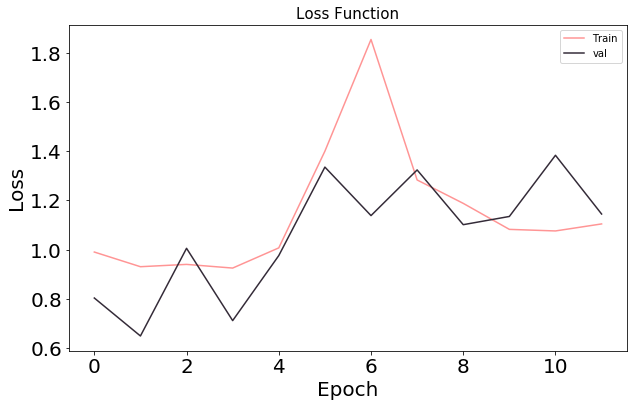

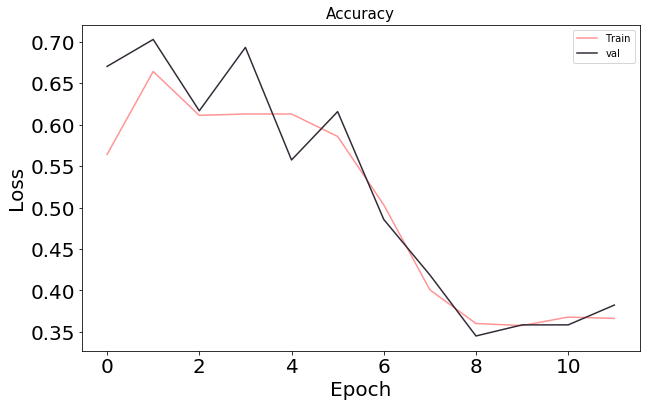

In [277]:
# plot the loss function #342b38
fig, ax = plt.subplots(1,1,figsize = (10,6))
ax.plot(history.history['loss'],color = '#ff9595',label = 'Train')
ax.plot(history.history['val_loss'],color = '#342b38',label = 'val')
ax.set_xlabel('Epoch',fontsize=20)
ax.set_ylabel('Loss',fontsize=20)
ax.set_title('Loss Function',fontsize = 15)
ax.legend()
ax.tick_params(labelsize=20)

# plot the accuracy
fig, ax = plt.subplots(1,1,figsize = (10,6))
ax.plot(history.history['accuracy'],color = '#ff9595',label = 'Train')
ax.plot(history.history['val_accuracy'],color = '#342b38',label = 'val')
ax.set_xlabel('Epoch',fontsize=20)
ax.set_ylabel('Loss',fontsize=20)
ax.set_title('Accuracy',fontsize = 15)
ax.legend()
ax.tick_params(labelsize=20)

# Evaluation and Testing

In [30]:
score = model.evaluate(x_train,y_train,verbose=0)
print(f"Training Accuracy: {score[1]}")

score = model.evaluate(x_test,y_test,verbose = 0)
print(f"Test Accuracy: {score[1]}")

Training Accuracy: 0.9862022399902344
Test Accuracy: 0.9682103395462036


In [75]:
def extract(file, pad = False):
    max_pad_len = 174
    try:
        data, sr = librosa.load(file)
        mfccs = librosa.feature.mfcc(data, sr = sr, n_mfcc = 25)
        if pad:
            # ensure that all files are the of fixed size
            pad_width = max_pad_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = librosa.util.normalize(np.mean(mfccs.T, axis = 0))
        
        
        
    except Exception as e:
        print(f"An error occured when trying to load {os.path.basename(file)} {e}")
        return None
    
    return np.array([mfccs])

def prediction(filename, pad = False):
    # get the MFCC for the file
    feature = extract(filename)
    
    
    # predicting the class (predict_classes() for classification, predict() for regression)
    pvector = model.predict_classes(feature)
    # Transform labels back to original encoding
    label = le.inverse_transform(pvector)
    print(f"The predicted category is: {label[0]}")
    
    # predict the probability for each category
    probability = model.predict_proba(feature)[0]
    #print(probability)
    for p in range(len(probability)):
        category = le.inverse_transform(np.array([p]))
        print(f"{category[0]}\t: {round(probability[p], 5)}")
    
    

In [79]:
file = r'E:\Sample library\Spring\Samplified Packs\Samplified Bounce pack\01 - Drums & Percs\Kicks\Kick 3.wav'
prediction(file)

The predicted category is: Kick
Kick	: 0.998740017414093
Snare	: 0.0012600000482052565
